In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from util.attribution_methods.VIT_LRP.ViT_explanation_generator import Baselines, LRP

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch16_224 as vit_new
    from util.attribution_methods.VIT_LRP.ViT_LRP_timm import vit_base_patch16_224 as vit_LRP
    num_patches = 14
    
from util import model_utils
from util.visualization import attr_to_subplot

# Model
model = vit_new(pretrained=True).cuda()
model_lrp = vit_LRP(pretrained=True).cuda()

explainer = Baselines(model)
LRP_explainer = LRP(model_lrp)

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

plt.rcParams.update({'font.size': 25})

In [2]:
image_path = "sub.JPEG"

83.55630040168762 833 submarine


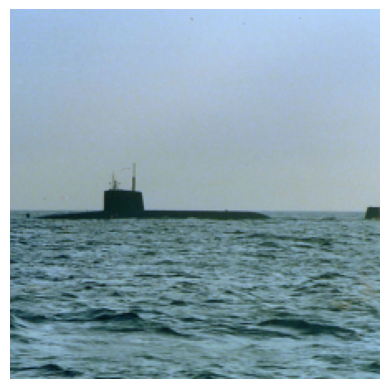

In [3]:
image = Image.open(image_path)
image = transform(image)

tensor_image = normalize(image).unsqueeze(0)

target_class = model_utils.getClass(tensor_image, model, 'cuda:0', k = 0)
with open('util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]

print(model_utils.getPrediction(tensor_image, model, 'cuda:0', target_class)[0] * 100, target_class.item(), name)

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

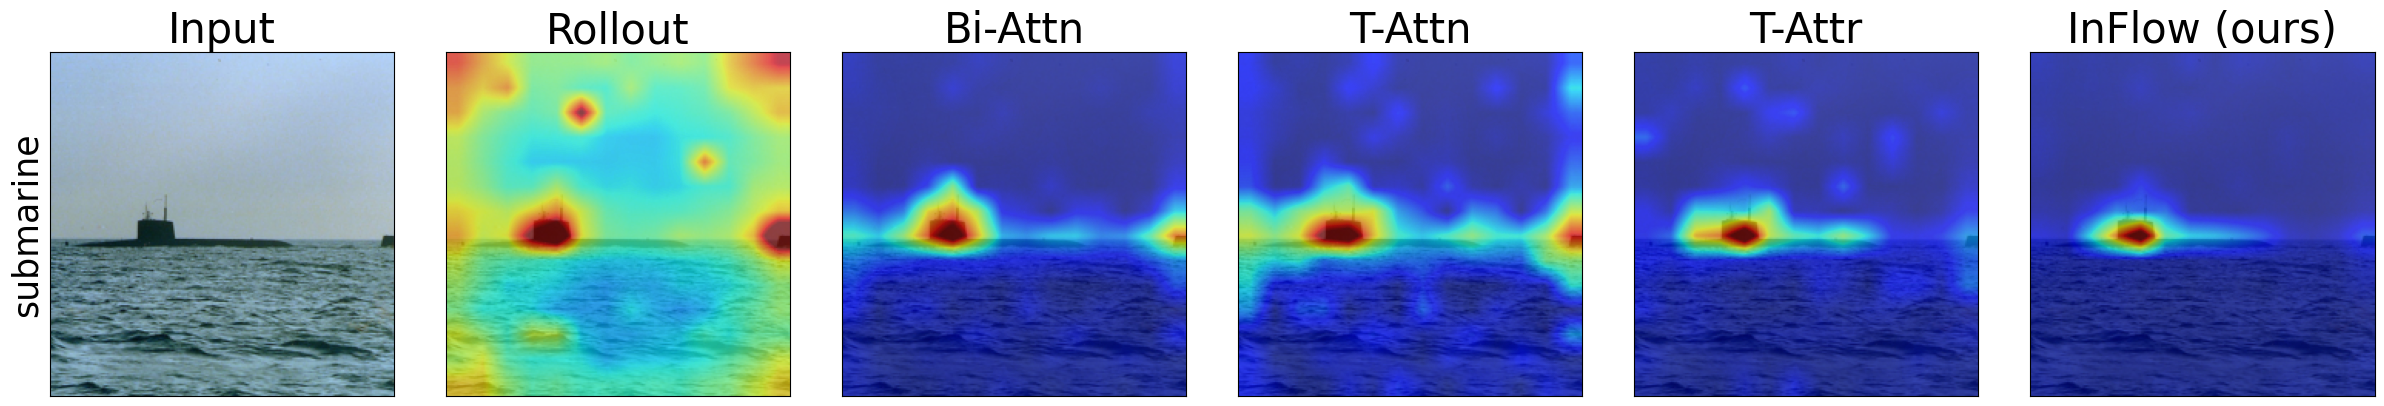

In [6]:
resize = transforms.Resize((224, 224), antialias = True)

# heatmap
def heatmap_overlap_axs(img, attr, name, axs, alpha = 0.66):
    attr = attr.detach().cpu().numpy()
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img, alpha = alpha)
    return

# All ViT attributions are produced as (1, M, M) matrix where M is the number of patches per side
# For this ViT-base-16 model, the size is (1, 14, 14) and we upscale the atr to (1, 224, 224) with the resize
def compare():
    _, axs = plt.subplots(1, 6, figsize = (30, 6))

    attr_to_subplot(image, "Input", axs[0], original_image = True)
    axs[0].set_ylabel(name.replace(" ", "\n"))

    attr, _, _ = explainer.generate_rollout(tensor_image.to("cuda:0"))
    attr = resize(attr.cpu().detach())
    heatmap_overlap_axs(image, attr.permute(1, 2, 0), 'Rollout', axs[1])

    attr, _ = explainer.bidirectional(tensor_image.to("cuda:0"), target_class)
    attr = resize(attr.cpu().detach())
    heatmap_overlap_axs(image, attr.permute(1, 2, 0), 'Bi-Attn', axs[2])

    _, _, attr, _, _ = explainer.generate_transition_attention_maps(tensor_image.to("cuda:0"), target_class, start_layer = 0)
    attr = resize(attr.cpu().detach())
    heatmap_overlap_axs(image, attr.permute(1, 2, 0), 'T-Attn', axs[3])

    attr = LRP_explainer.generate_LRP(tensor_image.cuda(), target_class, method="transformer_attribution", start_layer = 0)
    attr = resize(attr.cpu().detach())
    heatmap_overlap_axs(image, attr.permute(1, 2, 0), 'T-Attr', axs[4])

    # Here is the InFlow call, it is used in the same way as standardized by the Chefer repository
    InFlow, _ = explainer.generate_InFlow(tensor_image.to("cuda:0"), target_class)
    InFlow = resize(InFlow.cpu().detach())
    heatmap_overlap_axs(image, (InFlow).permute(1, 2, 0), 'InFlow (ours)', axs[5])

    plt.subplots_adjust(hspace = 0.12, wspace = 0.15)

compare()